### Prerequisites:

 - We will use [pandas](https://pandas.pydata.org/docs/) for data processing,
 - and Meta's open-source LLM [Llama 3.1](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct) for prompting and few-shot learning.
- All experiments will be performed on the [Web of Science (WOS46985) Dataset](https://huggingface.co/datasets/HDLTex/web_of_science#wos46985).

In [1]:
%%capture
# install dependecies:
!pip install numpy torch pandas scikit-learn transformers tqdm datasets

### Data processing

In [2]:
from datasets import load_dataset

data = load_dataset("HDLTex/web_of_science", 'WOS46985')
data = data['train'].to_pandas()
data.sample()

/home/v25/ippa6201/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,input_data,label,label_level_1,label_level_2
33505,"The alignment of many short sequences of DNA, ...",125,6,0


We use the `label` from the `input_data` of the scientific article as the target label to predict:

In [3]:
# select input and label from data:
X = data['input_data'].to_numpy()
y = data['label'].astype(str).to_numpy()

In [4]:
# find the most 15 frequent classes and keep only those:
from collections import Counter

counter = Counter(y)
most_common_classes = [cls for cls, count in counter.most_common(15)]
print('Most common classes: ', most_common_classes) 

idxs = [i for i, label in enumerate(y) if label not in most_common_classes]
X = [x for i, x in enumerate(X) if i not in idxs]
y = [label for i, label in enumerate(y) if i not in idxs]

Most common classes:  ['131', '125', '132', '128', '25', '127', '130', '129', '126', '133', '40', '65', '17', '2', '7']


In [5]:
from sklearn.model_selection import train_test_split

# create test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42, shuffle=True, stratify=y)
print('Size of test set : ', len(X_test))
print('Size of train set: ', len(X_train))
classes = set(y_train)
print('Classes: ', len(classes))

Size of test set :  863
Size of train set:  7763
Classes:  15


### Random Example Fetcher

In [6]:
import numpy as np

def fetch_random_train_vectors(train_vectors, k=1, seed=None):
    """
    Randomly select k indices from the training set.

    Args:
        train_vectors: A matrix or array representing training data (used only to determine size).
        k: Number of random indices to select.
        seed: Optional random seed for reproducibility.

    Returns:
        A list of k random indices from the training set.
    """
    if seed is not None:
        np.random.seed(seed)
        
    n = len(train_vectors)
    return np.random.choice(n, size=k, replace=False)

### Sparse Frequency-based Embeddings for Similarity

We import TfidfVectorizer from `sklearn.feature_extraction.text` and use it to create and fit a TF-IDF input embedding on the `X_train` data. Since `TfidfVectorizer.transform(...)` returns a sparse matrix.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
# create and train input embedding:
tfidf = TfidfVectorizer().fit(X_train)

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def fetch_most_similar_train_vectors(test_vector, train_vectors, k=1):
    """
    For a given test TF-IDF vector, find the k most similar train TF-IDF vectors
    using cosine similarity.

    Args:
        test_vector: The TF-IDF vector for a single test instance.
        train_vectors: A sparse matrix of TF-IDF vectors for the training set.
        k: The number of most similar vectors to return.

    Returns:
        A list of indices of the k most similar train vectors.
    """
    # Calculate cosine similarity between the test vector and all train vectors
    # Reshape test_vector to be a 2D array for cosine_similarity
    similarities = cosine_similarity(test_vector.reshape(1, -1), train_vectors)

    # Get the indices of the top k most similar vectors
    # Use argsort to get indices in ascending order, then slice the last k
    # Flatten similarities to a 1D array for argsort
    most_similar_indices = np.argsort(similarities.flatten())[-k:]

    return most_similar_indices[::-1] # Return indices in descending order of similarity

In [9]:
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

t = X_test_tfidf[0] # test text
n = 3 # shots
similar_indices = fetch_most_similar_train_vectors(t, X_train_tfidf, k=n)
print(f"Most similar train indices for the first test sample\n'{X_test[0]}' (n={n}):{similar_indices}\n")
for i, idx in enumerate(similar_indices): print(i+1, X_train[idx])

Most similar train indices for the first test sample
'Background: The essential metals, chromium (Cr), magnesium (Mg), manganese (Mn) and zinc (Zn), are necessary for many metabolic processes and their homeostasis is crucial for life. The toxic metals, cadmium (Cd) and lead (Pb), have no beneficial role in human metabolism. The aim of this study was to investigate the levels of Cd, Cr, Mg, Mn, Pb, and Zn in scalp hair samples of type 2 diabetes mellitus patients of both genders, ages ranging from 30 to 50 y, and belong to urban areas of Ireland and Pakistan. For comparison purposes, age matched non-diabetic subjects of both countries were selected as referents. Methods: The concentrations of metals in scalp hair samples were measured by inductively coupled plasma atomic emission spectrophotometer and atomic absorption spectrophotometer after microwave-assisted acid digestion. The validity and accuracy of the methodology were checked by conventional wet-acid-digestion method and using c

### Instantiate Llama

In order to be able to use huggingface's Llama 3.1 models, we first need to log in to huggingface (you can request access to the model [here](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct)).

In [10]:
import getpass
from huggingface_hub import login
login(getpass.getpass('Enter your huggingface API-key:'))

In this tutorial we will use the standard huggingface textgeneration pipeline (compressed to 16 bit floating point weights) for the instruction tuned 8B parameter version of Llama 3.1.

In [11]:
%%capture
import transformers
import torch

# create llm pipeline:
llm = transformers.pipeline(
    "text-generation",
    model="meta-llama/Meta-Llama-3.1-8B-Instruct",
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto"
)

# Get special tokens for later:
bos_token_id = llm.tokenizer.convert_tokens_to_ids('<|begin_of_text|>')
eos_token_id = llm.tokenizer.convert_tokens_to_ids('<|eot_id|>')
pad_token_id = llm.tokenizer.convert_tokens_to_ids('<|eot_id|>')

### Few-shot learning with Random Examples

Generate a prompt for classification using a given text and $n$ labeled examples.

In [21]:
def get_prompt(text, shots):
    prompt = 'We classify scientific article labels from texts, as in the following examples:\n'
    for x,y in shots: prompt += f'\n"{x}": {y}'
    return {"role": "user", "content": f'{prompt}\n\nThe valid labels are: {", ".join(classes)}.\nPredict the correct label for the following text, but generate only the label and no other text.\n\n"{text}": '}

shots_idxs = fetch_random_train_vectors(X_train, k=n, seed=42)
shots = [(X_train[idx], y_train[idx]) for idx in shots_idxs]
prompt = get_prompt(X_test[0], shots)["content"]
print(prompt)

We classify scientific article labels from texts, as in the following examples:

"1. Metabolism of ABT-107 was investigated in in vitro hepatic systems, in rat and monkey receiving [C-14] ABT-107, and in vivo plasma in rat, dog, monkey and human. 2. In in vitro hepatic systems, ABT-107 was primarily cleared via oxidative metabolism, and proceeded via two parallel pathways. Pathway 1, ABT-107 was oxidized at the nitrogen of quinuclidine moiety to form M1. Pathway 2, oxidation occurred at indole-containing moiety to form M2. Metabolism via N-oxidation was predominant in dog and rat, while in monkey and human, metabolism proceeded primarily via oxidation of indole-containing moiety. 3. ABT-107 was extensively metabolized in vivo in rat and monkey. M1 was primarily found in rat urine and bile; whereas, M2 was the major metabolite in monkey urine and feces. M1 was the predominant circulating metabolite in dog and rat. M2 was the primary circulating metabolite in monkey and human. 4. Enzymat

In [22]:
from tqdm import tqdm

def few_shot_learning_batch(test, test_tfidf, train, train_tfidf, y_train, n=3):
  outputs = []
  for i,t in tqdm(enumerate(X_test_tfidf), total=len(test)):
      shots_idxs = fetch_random_train_vectors(train, k=n, seed=42) 
      shots = [(train[idx], y_train[idx]) for idx in shots_idxs]
      prompt = get_prompt(test[i], shots)["content"]
      response = llm([prompt],
                    bos_token_id=bos_token_id,
                    eos_token_id=eos_token_id,
                    pad_token_id=pad_token_id,
                    max_new_tokens=1,
                    do_sample=False,
                    temperature=None,
                    top_p=None)
      label = response[0][0]["generated_text"].split(':')[-1].strip()
      outputs.append(label)
  return outputs

predictions = few_shot_learning_batch(X_test, X_test_tfidf, X_train, X_train_tfidf, y_train, n=3)

100%|██████████| 863/863 [05:24<00:00,  2.66it/s]


In [23]:
predictions[:10]

['127', '127', '127', '130', '127', '130', '127', '127', '130', '127']

Classification Report:
               precision    recall  f1-score   support

         125       0.00      0.00      0.00        75
         126       0.00      0.00      0.00        56
         127       0.08      0.87      0.15        62
         128       0.22      0.03      0.05        65
         129       0.00      0.00      0.00        57
         130       0.06      0.21      0.09        58
         131       0.00      0.00      0.00        75
         132       0.00      0.00      0.00        70
         133       0.00      0.00      0.00        51
          17       0.00      0.00      0.00        45
           2       0.00      0.00      0.00        44
          25       0.00      0.00      0.00        65
          40       0.00      0.00      0.00        51
          65       0.00      0.00      0.00        45
           7       0.00      0.00      0.00        44

    accuracy                           0.08       863
   macro avg       0.02      0.07      0.02       863
we

Text(0.5, 1.0, 'Confusion Matrix')

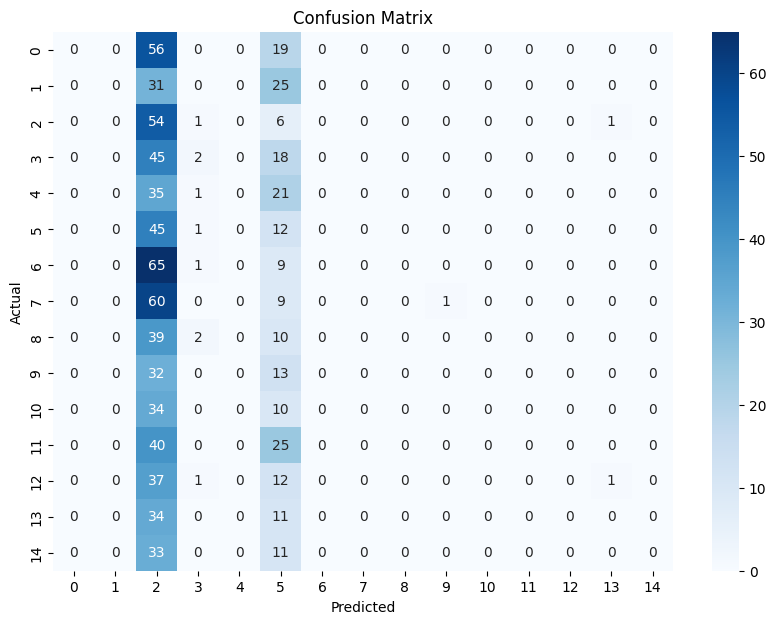

In [24]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def clean(labels, classes=classes, lim=4):
  labels = [lbl if lbl in classes else 'other' for lbl in labels]
  labels_short = [lbl[:lim] for lbl in labels]
  return labels_short

print("Classification Report:\n", classification_report(clean(y_test), clean(predictions), zero_division=0))
print("Accuracy:", accuracy_score(clean(y_test), clean(predictions)))

# Plot confusion matrix
cm = confusion_matrix(clean(y_test), clean(predictions))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

### Few-shot learning with Most Similar Examples

Generate a prompt for classification using a given text and $n$ labeled examples.

In [16]:
def get_prompt(text, shots):
    prompt = 'We classify scientific article labels from texts, as in the following examples:\n'
    for x,y in shots: prompt += f'\n"{x}": {y}'
    return {"role": "user", "content": f'{prompt}\n\nThe valid labels are: {", ".join(classes)}.\nPredict the correct label for the following text, but generate only the label and no other text.\n\n"{text}": '}

shots_idxs = fetch_most_similar_train_vectors(X_test_tfidf[0], X_train_tfidf, k=n)
shots = [(X_train[idx], y_train[idx]) for idx in shots_idxs]
prompt = get_prompt(X_test[0], shots)["content"]
print(prompt)

We classify scientific article labels from texts, as in the following examples:

"A total of 211 water samples were collected from 53 key sampling points from 5-10th July 2013 at four different depths (0 m, 2 m, 4 m, 8 m) and at different sites in the Huaihe River, Anhui, China. These points monitored for 18 parameters (water temperature, pH, TN, TP, TOC, Cu, Pb, Zn, Ni, Co, Cr, Cd, Mn, B, Fe, Al, Mg, and Ba). The spatial variability, contamination sources and health risk of trace elements as well as the river Water quality were investigated. Our results were compared with national (CSEPA) and international (WHO, USEPA) drinking water guidelines, revealing that Zn, Cd and Pb were the dominant pollutants in the water body. Application of different multivariate statistical approaches, including correlation matrix and factor/principal component analysis (FA/PCA), to assess the origins of the elements in the Huaihe River, identified three source types that accounted for 79.31% of the total

In [17]:
from tqdm import tqdm

def few_shot_learning_batch(test, test_tfidf, train, train_tfidf, y_train, n=3):
  outputs = []
  for i,t in tqdm(enumerate(X_test_tfidf), total=len(test)):
      shots_idxs = fetch_most_similar_train_vectors(t, train_tfidf, k=n)
      shots = [(train[idx], y_train[idx]) for idx in shots_idxs]
      prompt = get_prompt(test[i], shots)["content"]
      response = llm([prompt],
                    bos_token_id=bos_token_id,
                    eos_token_id=eos_token_id,
                    pad_token_id=pad_token_id,
                    max_new_tokens=1,
                    do_sample=False,
                    temperature=None,
                    top_p=None)
      label = response[0][0]["generated_text"].split(':')[-1].strip()
      outputs.append(label)
  return outputs

predictions = few_shot_learning_batch(X_test, X_test_tfidf, X_train, X_train_tfidf, y_train, n=3)

100%|██████████| 863/863 [05:12<00:00,  2.76it/s]


In [18]:
predictions[:10]

['128', '7', '128', '17', '2', '130', '17', '131', '25', '25']

Classification Report:
               precision    recall  f1-score   support

         125       0.27      0.12      0.17        75
         126       0.48      0.23      0.31        56
         127       0.54      0.60      0.57        62
         128       0.17      0.71      0.27        65
         129       0.60      0.11      0.18        57
         130       0.48      0.55      0.52        58
         131       0.54      0.35      0.42        75
         132       0.46      0.16      0.23        70
         133       0.11      0.08      0.09        51
          17       0.73      0.67      0.70        45
           2       0.79      0.84      0.81        44
          25       0.95      0.89      0.92        65
          40       0.66      0.65      0.65        51
          65       0.71      0.64      0.67        45
           7       0.77      0.61      0.68        44
        othe       0.00      0.00      0.00         0

    accuracy                           0.46       863
  

Text(0.5, 1.0, 'Confusion Matrix')

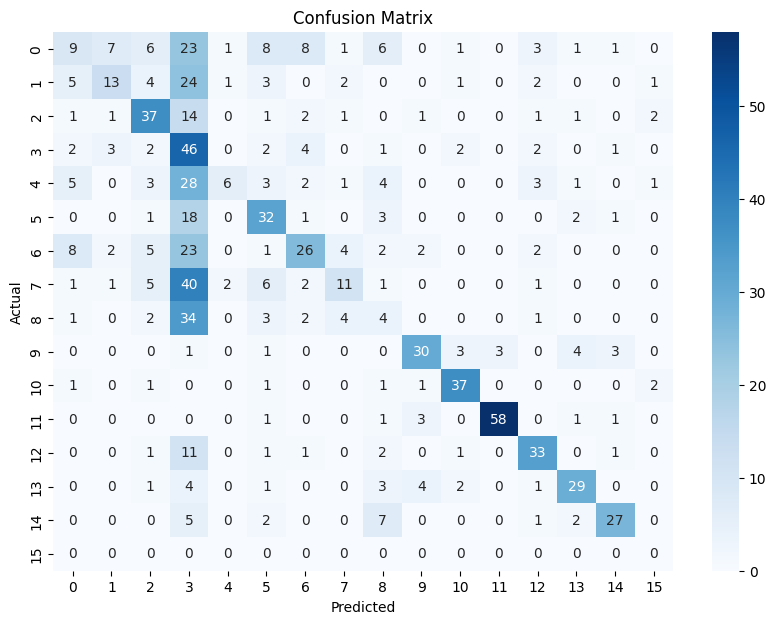

In [20]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def clean(labels, classes=classes, lim=4):
  labels = [lbl if lbl in classes else 'other' for lbl in labels]
  labels_short = [lbl[:lim] for lbl in labels]
  return labels_short

print("Classification Report:\n", classification_report(clean(y_test), clean(predictions), zero_division=0))
print("Accuracy:", accuracy_score(clean(y_test), clean(predictions)))

# Plot confusion matrix
cm = confusion_matrix(clean(y_test), clean(predictions))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')